# Advanced Lane Finding Project 

By Pablo Sauras Perez

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---
## 1. Compute the camera calibration using chessboard images
This code is was available in 'examples/example.ipynb'

In [256]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

In [257]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)

# chessboard
ny = 6
nx = 9

objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = 'output_images/calibration_corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        cv2.imshow(write_name,img)
        cv2.waitKey(50)
        
cv2.destroyAllWindows()

### Calibrate, Calculate Distortion Coefficients and test undistorsion on an image
This code is from 'CarND-Camera-Calibration'

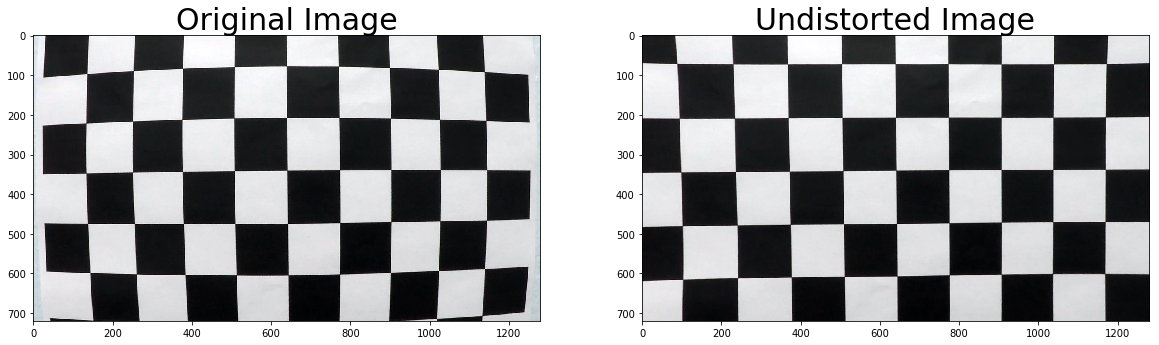

In [258]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
#mtx --> Calibration Matrix
#dist --> Distortion Coeficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

#Calculate distortion coefficients
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/undistorded_calibration.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
#I apply mtx and dist to each new frame
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Pipeline (single images)

## 2. Apply a distortion correction to raw images

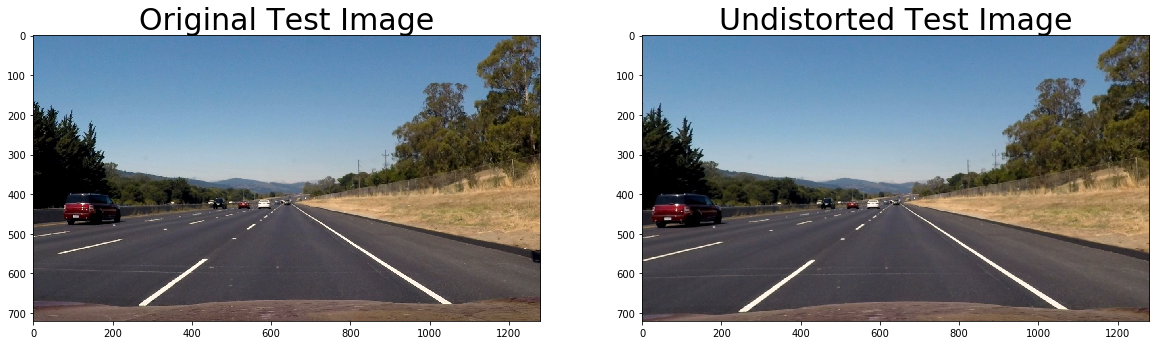

In [458]:
# Test undistortion on an image
img = cv2.imread('test_images/straight_lines2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Calculate distortion coefficients
dst = cv2.undistort(img, mtx, dist, None, mtx)

cv2.imwrite('output_images/undistorded_test.jpg',cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Test Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Test Image', fontsize=30)

## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

This is the Thresholding step. Here I want to use various combinations of color and gradient thresholds to generate a binary image where the lane lines are clearly visible.

In [459]:
# Edit this function to create your own pipeline.
def pipeline_threshold(img, s_thresh=(170, 255), sx_thresh=(30, 100)):
    img = np.copy(img)
    
    r_channel = img[:,:,2]
    g_channel = img[:,:,1]
    b_channel = img[:,:,0]
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float)
    h_channel = hsv[:,:,0]
    s_channel = hsv[:,:,1]
    v_channel = hsv[:,:,2]
    
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobely = cv2.Sobel(v_channel, cv2.CV_64F, 0, 1) # Take the derivative in y
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    abs_sobely = np.absolute(sobely) # Absolute y derivative to accentuate lines away from vertical
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel_mag = np.uint8(255*gradmag/np.max(gradmag))
    
    thresh_d=(0.5, 1.3)
    
    #direction of the gradient
    direction =  np.arctan2(abs_sobely, abs_sobelx)
        
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[((scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1]))] = 1
    
    # Threshold magnitude
    s_mag_binary = np.zeros_like(scaled_sobel_mag)
    s_mag_binary[((scaled_sobel_mag >= sx_thresh[0]) & (scaled_sobel_mag <= sx_thresh[1]))] = 1
    
    # Threshold x gradient
    s_dir_binary = np.zeros_like(scaled_sobel)
    s_dir_binary[((direction >= thresh_d[0]) & (direction <=  thresh_d[1]))] = 1
    
    #sxbinary[(sxbinary == 1) | ((s_mag_binary == 1) & (s_dir_binary == 1))] = 1
    
    #binary_output_direction = np.zeros_like(direction)
    #binary_output_direction[(direction_direction >= thresh_d[0]) & (direction_direction <=  thresh_d[1])] = 1
    
    # Threshold color channel S
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    h_thresh = (15, 100)
    # Threshold color channel H
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
    v_thresh = (220, 255)
    # Threshold color channel V
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    
    l_thresh = (15, 100)
    # Threshold color channel H
    #l_binary = np.zeros_like(l_channel)
    l_binary = l_channel
    
    #l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    color_binary = np.dstack(( v_binary, sxbinary, s_binary))
    
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    #combined_binary[((s_binary == 1) & (s_dir_binary == 1) & (s_mag_binary == 1)) | (sxbinary == 1)] = 1
    #combined_binary[((s_binary == 1) & (h_binary == 1)) | ((sxbinary == 1) & (s_dir_binary == 1)) ] = 1
    combined_binary[((sxbinary == 1) | (v_binary == 1))] = 1
    #combined_binary[(v_binary == 1) ] = 1
    #color_binary = v_channel
    color_binary = combined_binary
    
    
    return color_binary

Apply threshold pipeline and show one of the test results

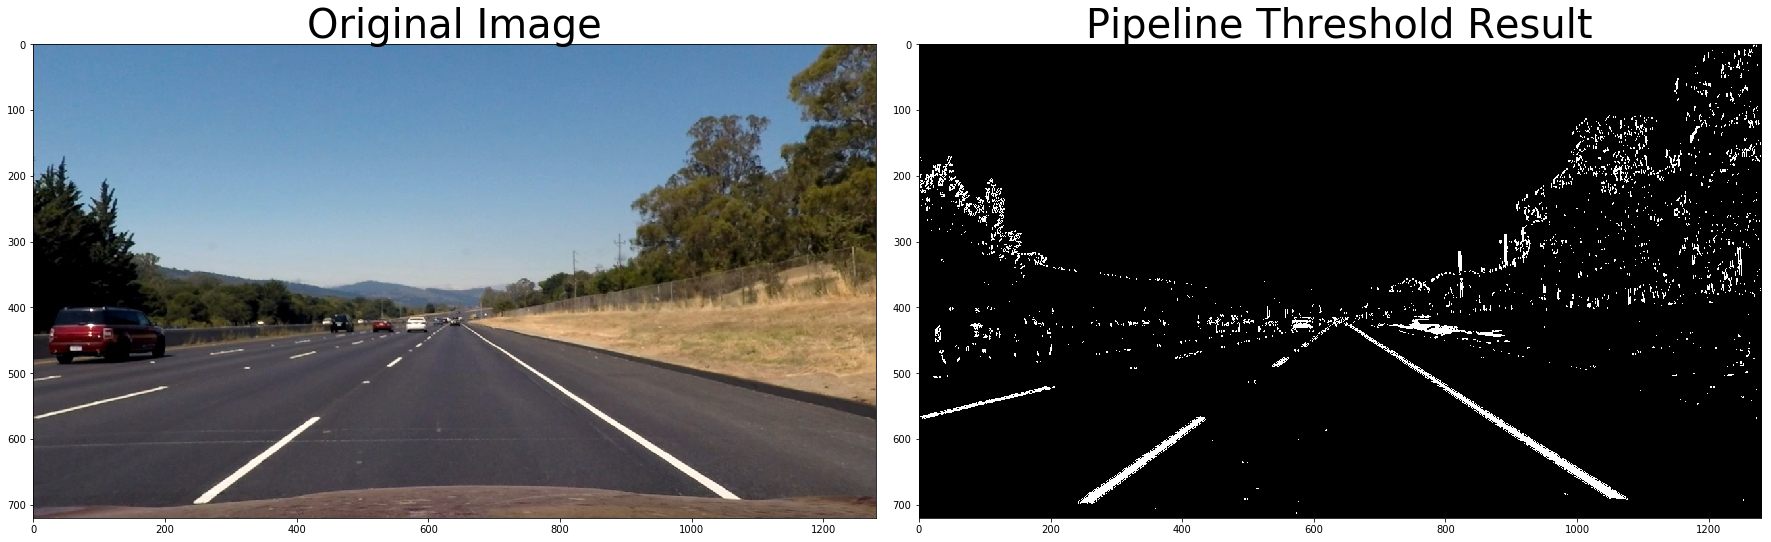

In [460]:
image = dst
undst = dst
color_binary = pipeline_threshold(image)


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(color_binary, cmap = 'gray')
ax2.set_title('Pipeline Threshold Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 4. Apply a perspective transform to rectify binary image ("birds-eye view").

In [461]:
#I already have mtx --> Calibration Matrix
# and dist --> Distortion Coeficients
#from the camera calibration of step 1... so I use them

def corners_unwarp(img, mtx, dist):

    # Undistort using mtx and dist   
    undst = cv2.undistort(img, mtx, dist, None, mtx)  
    img_size =(undst.shape[1], undst.shape[0])
    
    #top-right
    #bottom-right
    #bottom-left
    #top-left
    
    #source points (trapezoid)  
    src = np.float32(
    [[580, 460],
     [195, 720],
     [1127, 720],
     [705, 460]])
    
   
    #destination points (a rectangle)        
    dst = np.float32(
    [[200, 0],
     [200, 720],
     [950, 720], 
     [950, 0]])
    
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    #calculate the inverse as well
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    #use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(undst, M, img_size, flags=cv2.INTER_LINEAR)
 
    return warped, M, Minv, src, dst

Apply it the perspective transform

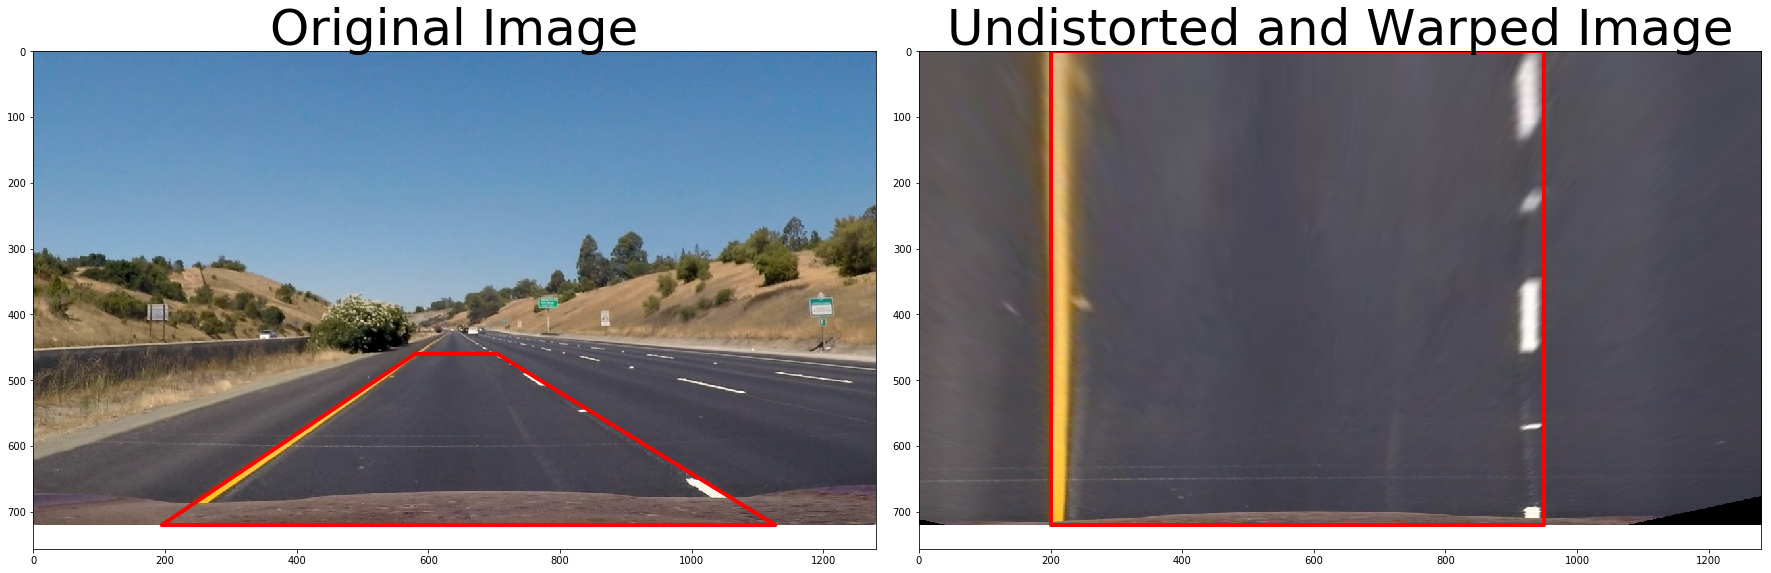

In [462]:
# Test on an image where lines are straight
img = cv2.imread('test_images/straight_lines1.jpg')

top_down, perspective_M, perspective_Minv, src, dst = corners_unwarp(img, mtx, dist)

x_src = [src[0][0], src[1][0], src[2][0], src[3][0], src[0][0]]
y_src = [src[0][1], src[1][1], src[2][1], src[3][1], src[0][1]]

x_dst = [dst[0][0], dst[1][0], dst[2][0], dst[3][0], dst[0][0]]
y_dst = [dst[0][1], dst[1][1], dst[2][1], dst[3][1], dst[0][1]]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.plot(x_src, y_src, 'r-', lw=4)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(cv2.cvtColor(top_down, cv2.COLOR_BGR2RGB))
ax2.plot(x_dst, y_dst, 'r-', lw=4)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


Now I apply perspective transform to rectify binary image

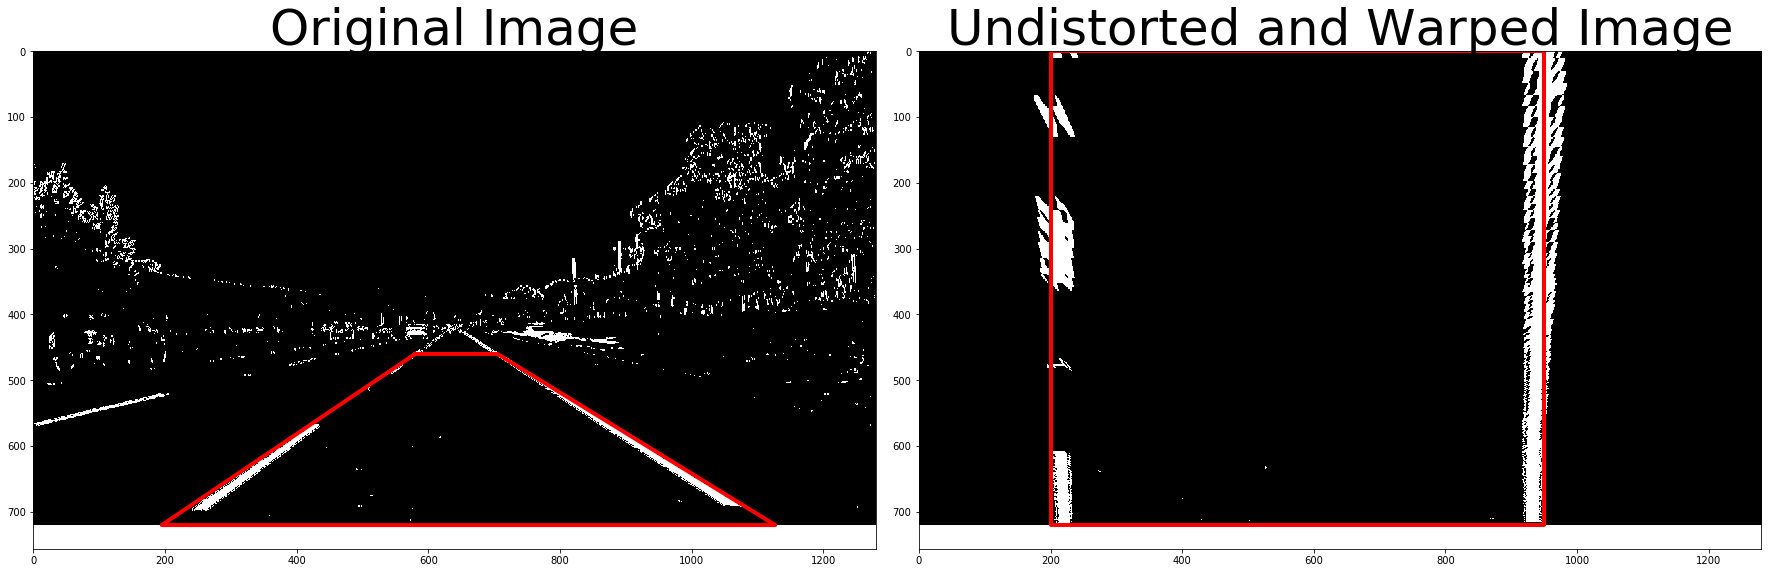

In [463]:
binary_warped, perspective_M, perspective_Minv, src, dst = corners_unwarp(color_binary, mtx, dist)

x_src = [src[0][0], src[1][0], src[2][0], src[3][0], src[0][0]]
y_src = [src[0][1], src[1][1], src[2][1], src[3][1], src[0][1]]

x_dst = [dst[0][0], dst[1][0], dst[2][0], dst[3][0], dst[0][0]]
y_dst = [dst[0][1], dst[1][1], dst[2][1], dst[3][1], dst[0][1]]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(color_binary, cmap='gray')
ax1.plot(x_src, y_src, 'r-', lw=4)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(binary_warped, cmap='gray')
ax2.plot(x_dst, y_dst, 'r-', lw=4)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## 5. Detect lane pixels and fit to find the lane boundary.

In [464]:
def lane_boundary_sl_wi(binary_warped, histogram, nwindows, margin, minpix):
    
    # Take a histogram of the bottom half of the image
    #histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #plt.plot(histogram)

    # Create an output image to draw on and  visualize the result
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    #nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    #margin = 100
    # Set minimum number of pixels found to recenter window
    #minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0], binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_lane_inds, left_fit, right_lane_inds, right_fit, nonzerox, nonzeroy, ploty, left_fitx, right_fitx

### Call the function

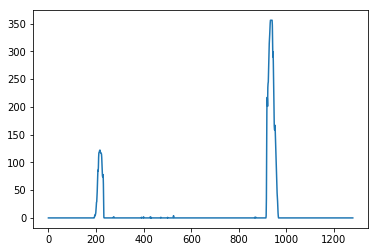

In [465]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

#Call the function
nwindows = 9
margin = 75
minpix = 50

histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
    
left_lane_inds, left_fit, right_lane_inds, right_fit, nonzerox, nonzeroy, ploty, left_fitx, right_fitx = lane_boundary_sl_wi(binary_warped, histogram, nwindows, margin, minpix)

### Visualization


(720, 0)

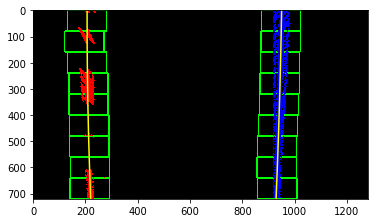

In [466]:
# Generate x and y values for plotting
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## 6. Determine the curvature of the lane and vehicle position with respect to center

First I do Radius in Pixels

In [467]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
def rad_cur_px(ploty, y_eval, left_fit, right_fit):
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print('Left Radius: ', left_curverad)
    print('Right Radius: ', right_curverad)
    
    return left_curverad, right_curverad

Call the function

In [468]:
y_eval = np.max(ploty)
left_curverad, right_curverad = rad_cur_px(ploty, y_eval, left_fit, right_fit)

Left Radius:  16799.4365627
Right Radius:  28402.4502445


Now we have to convert this to the real world space. 
Assume (as indicated in the lesson) hat if you're projecting a section of lane similar to the images above, the lane is about 30 meters long and 3.7 meters wide. Or, if you prefer to derive a conversion from pixel space to world space in your own images, compare your images with U.S. regulations that require a minimum lane width of 12 feet or 3.7 meters, and the dashed lane lines are 10 feet or 3 meters long each.

In [469]:
def rad_cur_m(ploty, y_eval, left_fitx, right_fitx, ym_per_pix, xm_per_pix):


    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print('Left curvature: ', left_curverad, 'm')
    print('Right curvature: ', right_curverad, 'm')

    R_avg = (left_curverad + right_curverad)/2

    curv_str = "Radius of Curvature: %im" % abs(R_avg)
    print(curv_str)
    
    return curv_str, left_fit_cr, right_fit_cr

Call the function

In [470]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/750 # meters per pixel in x dimension
curv_str, left_fit_cr, right_fit_cr = rad_cur_m(ploty, y_eval, left_fitx, right_fitx, ym_per_pix, xm_per_pix)

Left curvature:  5897.67990097 m
Right curvature:  9968.94421713 m
Radius of Curvature: 7933m


## Offset calculation

In [471]:
def lateral_offset(binary_warped, left_fit_cr, right_fit_cr, xm_per_pix, ym_per_pix):
    
    #Calculate distance at the bottom of the image
    left_fit_cr_eval = left_fit_cr[0]*y_eval*ym_per_pix**2 + left_fit_cr[1]*y_eval*ym_per_pix + left_fit_cr[2]
    right_fit_cr_eval = right_fit_cr[0]*y_eval*ym_per_pix**2 + right_fit_cr[1]*y_eval*ym_per_pix + right_fit_cr[2]

    image_center = (binary_warped.shape[1]/2)*xm_per_pix #Convert to m
    lane_center = (right_fit_cr_eval + left_fit_cr_eval)/2 #Already in m

    offset = image_center - lane_center

    if offset > 0:
        offset_str = "Vehicle is %.2fm left of center" % abs(offset)
        print(offset_str)
    elif offset < 0:
        offset_str = "Vehicle is %.2fm right of center" % abs(offset)
        print(offset_str)
    else:
        offset_str = "Vehicle is at center"
        print(offset_str)   
        
    return offset_str

Call the function

In [472]:
offset_str = lateral_offset(binary_warped, left_fit_cr, right_fit_cr, xm_per_pix, ym_per_pix)

Vehicle is 0.34m left of center


## 7. Warp the detected lane boundaries back onto the original image.

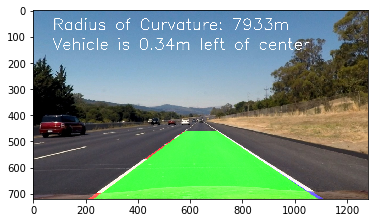

In [473]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))


# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=15)  
cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,0,255), thickness=15)


# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, perspective_Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undst, 1, newwarp, 0.8, 0)
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(result,curv_str,(75, 75), font, 2,(255,255,255),2, cv2.LINE_AA)
cv2.putText(result,offset_str,(75, 150), font, 2,(255,255,255),2, cv2.LINE_AA)
plt.imshow(result)

## Pipeline (Video)

In [394]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Define Line class

In [455]:
#Image
#mtx --> Calibration Matrix
#dist --> Distortion Coeficients
def process_image(image):
    #TODO: my code here
    #result = image
    
    # Read in the saved camera matrix and distortion coefficients
    # These are the arrays you calculated using cv2.calibrateCamera()
    dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

    img = image
    #1 . Distortion correction on images
    #img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #Calculate distortion coefficients
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    
    #2. Color / Gradient thresholding
    color_binary = pipeline_threshold(undst)
    
    #3. Unwrap  
    binary_warped, perspective_M, perspective_Minv, src, dst = corners_unwarp(color_binary, mtx, dist)
    
    #4. detect lane pixels to find lane boundary
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    #Call the function
    nwindows = 9
    margin = 75
    minpix = 50

    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #plt.plot(histogram)
    
    left_lane_inds, left_fit, right_lane_inds, right_fit, nonzerox, nonzeroy, ploty, left_fitx, right_fitx = lane_boundary_sl_wi(binary_warped, histogram, nwindows, margin, minpix)
    

    #5. Determine Rad Curvature
    # In pixels
    y_eval = np.max(ploty)
    left_curverad, right_curverad = rad_cur_px(ploty, y_eval, left_fit, right_fit)

    #In meters
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/640 # meters per pixel in x dimension
    curv_str, left_fit_cr, right_fit_cr = rad_cur_m(ploty, y_eval, left_fitx, right_fitx, ym_per_pix, xm_per_pix)
    
    #7. Calculate lateral offset
    offset_str = lateral_offset(binary_warped, left_fit_cr, right_fit_cr, xm_per_pix, ym_per_pix)
    
    #Plot results
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=15)  
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,0,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, perspective_Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undst, 1, newwarp, 0.8, 0)
    #plt.text(100, 75, curv_str, color='white')
    #plt.text(100, 150, offset_str, color='white')
    #plt.imshow(result)
    #result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,curv_str,(75, 75), font, 2,(255,255,255),2, cv2.LINE_AA)
    cv2.putText(result,offset_str,(75, 150), font, 2,(255,255,255),2, cv2.LINE_AA)
    return result

In [456]:
output_clip = "output_images/project_video_result.mp4"
clip = VideoFileClip("project_video.mp4")

clip_result = clip.fl_image(process_image)

%time clip_result.write_videofile(output_clip, audio=False)

Left Radius:  2017.48864564
Right Radius:  2326.19953007
Left curvature:  605.746436523 m
Right curvature:  698.342065807 m
Radius of Curvature: 652m
Vehicle is 0.67m right of center
Left Radius:  2017.48864564
Right Radius:  2326.19953007
Left curvature:  605.746436523 m
Right curvature:  698.342065807 m
Radius of Curvature: 652m
Vehicle is 0.67m right of center
[MoviePy] >>>> Building video output_images/project_video_result.mp4
[MoviePy] Writing video output_images/project_video_result.mp4


  1%|          | 1/126 [00:00<00:29,  4.27it/s]

Left Radius:  2017.48864564
Right Radius:  2326.19953007
Left curvature:  605.746436523 m
Right curvature:  698.342065807 m
Radius of Curvature: 652m
Vehicle is 0.67m right of center


  2%|▏         | 2/126 [00:00<00:29,  4.22it/s]

Left Radius:  2039.21308828
Right Radius:  2412.51940969
Left curvature:  612.316277988 m
Right curvature:  723.531112384 m
Radius of Curvature: 667m
Vehicle is 0.66m right of center


  2%|▏         | 3/126 [00:00<00:29,  4.16it/s]

Left Radius:  1862.21172326
Right Radius:  1553.99938393
Left curvature:  558.821939597 m
Right curvature:  466.186370564 m
Radius of Curvature: 512m
Vehicle is 0.85m right of center


  3%|▎         | 4/126 [00:00<00:29,  4.13it/s]

Left Radius:  1701.17252496
Right Radius:  1679.70597213
Left curvature:  509.89942996 m
Right curvature:  504.407070827 m
Radius of Curvature: 507m
Vehicle is 0.86m right of center


  4%|▍         | 5/126 [00:01<00:29,  4.16it/s]

Left Radius:  1666.52192504
Right Radius:  1787.32361255
Left curvature:  499.450411091 m
Right curvature:  536.447195193 m
Radius of Curvature: 517m
Vehicle is 0.85m right of center


  5%|▍         | 6/126 [00:01<00:28,  4.26it/s]

Left Radius:  1811.65852661
Right Radius:  2116.92650031
Left curvature:  543.879588819 m
Right curvature:  633.360777515 m
Radius of Curvature: 588m
Vehicle is 0.76m right of center


  6%|▌         | 7/126 [00:01<00:27,  4.28it/s]

Left Radius:  1840.624463
Right Radius:  2393.97466409
Left curvature:  552.733817483 m
Right curvature:  714.574096514 m
Radius of Curvature: 633m
Vehicle is 0.72m right of center


  6%|▋         | 8/126 [00:01<00:26,  4.41it/s]

Left Radius:  1934.24380251
Right Radius:  19708.4041353
Left curvature:  580.781124511 m
Right curvature:  5518.98276128 m
Radius of Curvature: 3049m
Vehicle is 0.51m right of center


  7%|▋         | 9/126 [00:02<00:26,  4.33it/s]

Left Radius:  1920.00017853
Right Radius:  111377.445971
Left curvature:  576.435172359 m
Right curvature:  30634.3460182 m
Radius of Curvature: 15605m
Vehicle is 0.48m right of center


  8%|▊         | 10/126 [00:02<00:26,  4.40it/s]

Left Radius:  2030.45054334
Right Radius:  70898.2540234
Left curvature:  608.991130488 m
Right curvature:  19543.6968016 m
Radius of Curvature: 10076m
Vehicle is 0.45m right of center


  9%|▊         | 11/126 [00:02<00:25,  4.46it/s]

Left Radius:  2114.27182566
Right Radius:  3682.97653235
Left curvature:  633.464155804 m
Right curvature:  1079.4103469 m
Radius of Curvature: 856m
Vehicle is 0.60m right of center


 10%|▉         | 12/126 [00:02<00:25,  4.44it/s]

Left Radius:  2309.3599374
Right Radius:  5531.19314505
Left curvature:  689.780188936 m
Right curvature:  1615.87301349 m
Radius of Curvature: 1152m
Vehicle is 0.51m right of center


 10%|█         | 13/126 [00:03<00:25,  4.42it/s]

Left Radius:  2438.96942602
Right Radius:  5265.93793486
Left curvature:  727.305772965 m
Right curvature:  1536.79421402 m
Radius of Curvature: 1132m
Vehicle is 0.50m right of center


 11%|█         | 14/126 [00:03<00:27,  4.08it/s]

Left Radius:  2408.01639177
Right Radius:  5080.88492486
Left curvature:  717.976586402 m
Right curvature:  1482.62058703 m
Radius of Curvature: 1100m
Vehicle is 0.50m right of center


 12%|█▏        | 15/126 [00:03<00:29,  3.76it/s]

Left Radius:  2595.59627317
Right Radius:  2940.06451687
Left curvature:  772.965692305 m
Right curvature:  866.729453051 m
Radius of Curvature: 819m
Vehicle is 0.56m right of center


 13%|█▎        | 16/126 [00:03<00:27,  3.98it/s]

Left Radius:  2327.49157085
Right Radius:  2127.77432233
Left curvature:  695.542195329 m
Right curvature:  631.541163415 m
Radius of Curvature: 663m
Vehicle is 0.67m right of center


 13%|█▎        | 17/126 [00:04<00:26,  4.05it/s]

Left Radius:  2718.24949936
Right Radius:  2471.33422406
Left curvature:  808.914586054 m
Right curvature:  729.302202732 m
Radius of Curvature: 769m
Vehicle is 0.58m right of center


 14%|█▍        | 18/126 [00:04<00:25,  4.23it/s]

Left Radius:  2593.08154259
Right Radius:  2830.96480631
Left curvature:  772.653222931 m
Right curvature:  829.036617688 m
Radius of Curvature: 800m
Vehicle is 0.55m right of center


 15%|█▌        | 19/126 [00:04<00:24,  4.36it/s]

Left Radius:  2756.05499481
Right Radius:  2968.41505512
Left curvature:  819.122491801 m
Right curvature:  872.660804351 m
Radius of Curvature: 845m
Vehicle is 0.52m right of center


 16%|█▌        | 20/126 [00:04<00:23,  4.42it/s]

Left Radius:  2998.56703851
Right Radius:  3476.71938514
Left curvature:  889.024680691 m
Right curvature:  1019.8293597 m
Radius of Curvature: 954m
Vehicle is 0.46m right of center


 17%|█▋        | 21/126 [00:04<00:23,  4.53it/s]

Left Radius:  3333.33838315
Right Radius:  4975.15491148
Left curvature:  983.941821742 m
Right curvature:  1446.14550128 m
Radius of Curvature: 1215m
Vehicle is 0.39m right of center


 17%|█▋        | 22/126 [00:05<00:22,  4.59it/s]

Left Radius:  3402.06292268
Right Radius:  8607.82948571
Left curvature:  1002.69624988 m
Right curvature:  2472.04906288 m
Radius of Curvature: 1737m
Vehicle is 0.33m right of center


 18%|█▊        | 23/126 [00:05<00:22,  4.48it/s]

Left Radius:  3733.78903751
Right Radius:  6521.99274892
Left curvature:  1097.49842734 m
Right curvature:  1899.31988636 m
Radius of Curvature: 1498m
Vehicle is 0.32m right of center


 19%|█▉        | 24/126 [00:05<00:22,  4.49it/s]

Left Radius:  3231.22079838
Right Radius:  3092.41141165
Left curvature:  956.186577789 m
Right curvature:  919.447560249 m
Radius of Curvature: 937m
Vehicle is 0.44m right of center


 20%|█▉        | 25/126 [00:05<00:22,  4.54it/s]

Left Radius:  3000.28345102
Right Radius:  2226.34458504
Left curvature:  891.784612595 m
Right curvature:  666.495797258 m
Radius of Curvature: 779m
Vehicle is 0.52m right of center


 21%|██        | 26/126 [00:06<00:22,  4.53it/s]

Left Radius:  3065.55078121
Right Radius:  2408.04641955
Left curvature:  910.571357801 m
Right curvature:  721.457774422 m
Radius of Curvature: 816m
Vehicle is 0.49m right of center


 21%|██▏       | 27/126 [00:06<00:21,  4.54it/s]

Left Radius:  2705.90979996
Right Radius:  3211.91935838
Left curvature:  807.749576168 m
Right curvature:  956.499053925 m
Radius of Curvature: 882m
Vehicle is 0.45m right of center


 22%|██▏       | 28/126 [00:06<00:21,  4.59it/s]

Left Radius:  2798.74887373
Right Radius:  3004.642321
Left curvature:  835.122903083 m
Right curvature:  899.772859402 m
Radius of Curvature: 867m
Vehicle is 0.44m right of center


 23%|██▎       | 29/126 [00:06<00:20,  4.64it/s]

Left Radius:  2540.10034862
Right Radius:  2854.59351423
Left curvature:  760.192600053 m
Right curvature:  854.546330383 m
Radius of Curvature: 807m
Vehicle is 0.48m right of center


 24%|██▍       | 30/126 [00:06<00:21,  4.54it/s]

Left Radius:  2375.74208155
Right Radius:  1715.46442549
Left curvature:  712.144701069 m
Right curvature:  515.154167143 m
Radius of Curvature: 613m
Vehicle is 0.66m right of center


 25%|██▍       | 31/126 [00:07<00:21,  4.49it/s]

Left Radius:  2090.15271476
Right Radius:  1816.09810746
Left curvature:  627.498098072 m
Right curvature:  544.766864797 m
Radius of Curvature: 586m
Vehicle is 0.68m right of center


 25%|██▌       | 32/126 [00:07<00:20,  4.55it/s]

Left Radius:  1867.82333277
Right Radius:  2078.82824749
Left curvature:  560.817514114 m
Right curvature:  620.573284814 m
Radius of Curvature: 590m
Vehicle is 0.67m right of center


 26%|██▌       | 33/126 [00:07<00:20,  4.56it/s]

Left Radius:  1940.16338663
Right Radius:  2909.81162814
Left curvature:  582.62890369 m
Right curvature:  860.359993646 m
Radius of Curvature: 721m
Vehicle is 0.59m right of center


 27%|██▋       | 34/126 [00:07<00:20,  4.50it/s]

Left Radius:  1839.12385381
Right Radius:  20096.0601891
Left curvature:  552.199162808 m
Right curvature:  5560.6365563 m
Radius of Curvature: 3056m
Vehicle is 0.46m right of center


 28%|██▊       | 35/126 [00:07<00:19,  4.56it/s]

Left Radius:  1780.0688738
Right Radius:  8177.73938225
Left curvature:  534.360216498 m
Right curvature:  2311.91357752 m
Radius of Curvature: 1423m
Vehicle is 0.51m right of center


 29%|██▊       | 36/126 [00:08<00:19,  4.64it/s]

Left Radius:  1794.31084089
Right Radius:  2388.51475539
Left curvature:  538.705849212 m
Right curvature:  708.70786573 m
Radius of Curvature: 623m
Vehicle is 0.67m right of center


 29%|██▉       | 37/126 [00:08<00:19,  4.53it/s]

Left Radius:  1702.68518767
Right Radius:  2701.34558484
Left curvature:  511.018020469 m
Right curvature:  796.639407051 m
Radius of Curvature: 653m
Vehicle is 0.66m right of center


 30%|███       | 38/126 [00:08<00:19,  4.44it/s]

Left Radius:  1595.21476232
Right Radius:  2920.77727709
Left curvature:  478.415005834 m
Right curvature:  856.559956732 m
Radius of Curvature: 667m
Vehicle is 0.68m right of center


 31%|███       | 39/126 [00:08<00:19,  4.54it/s]

Left Radius:  1502.08675949
Right Radius:  1732.90747847
Left curvature:  450.066473481 m
Right curvature:  517.66340319 m
Radius of Curvature: 483m
Vehicle is 0.85m right of center


 32%|███▏      | 40/126 [00:09<00:18,  4.62it/s]

Left Radius:  1487.48051916
Right Radius:  1514.46475379
Left curvature:  445.736818062 m
Right curvature:  454.044147976 m
Radius of Curvature: 449m
Vehicle is 0.91m right of center


 33%|███▎      | 41/126 [00:09<00:18,  4.50it/s]

Left Radius:  1471.79516351
Right Radius:  1758.72093296
Left curvature:  441.097740813 m
Right curvature:  525.030216141 m
Radius of Curvature: 483m
Vehicle is 0.86m right of center


 33%|███▎      | 42/126 [00:09<00:18,  4.44it/s]

Left Radius:  1446.50605668
Right Radius:  2068.60995906
Left curvature:  433.648146742 m
Right curvature:  615.143412108 m
Radius of Curvature: 524m
Vehicle is 0.81m right of center


 34%|███▍      | 43/126 [00:09<00:20,  4.12it/s]

Left Radius:  1440.95717836
Right Radius:  1594.77503762
Left curvature:  432.261814979 m
Right curvature:  477.405390893 m
Radius of Curvature: 454m
Vehicle is 0.93m right of center


 35%|███▍      | 44/126 [00:10<00:19,  4.32it/s]

Left Radius:  1565.79524442
Right Radius:  1729.50825501
Left curvature:  470.194667686 m
Right curvature:  517.813457464 m
Radius of Curvature: 494m
Vehicle is 0.85m right of center


 36%|███▌      | 45/126 [00:10<00:18,  4.45it/s]

Left Radius:  1622.27790535
Right Radius:  2049.24659384
Left curvature:  487.124692311 m
Right curvature:  611.07524472 m
Radius of Curvature: 549m
Vehicle is 0.79m right of center


 37%|███▋      | 46/126 [00:10<00:17,  4.57it/s]

Left Radius:  1647.19543273
Right Radius:  3600.35893706
Left curvature:  494.475473073 m
Right curvature:  1046.54940088 m
Radius of Curvature: 770m
Vehicle is 0.67m right of center


 37%|███▋      | 47/126 [00:10<00:17,  4.61it/s]

Left Radius:  1781.20409493
Right Radius:  5094.10594013
Left curvature:  534.139069193 m
Right curvature:  1458.1282415 m
Radius of Curvature: 996m
Vehicle is 0.59m right of center


 38%|███▊      | 48/126 [00:10<00:17,  4.40it/s]

Left Radius:  1791.28785412
Right Radius:  5198.02534437
Left curvature:  536.766668187 m
Right curvature:  1485.86546329 m
Radius of Curvature: 1011m
Vehicle is 0.59m right of center


 39%|███▉      | 49/126 [00:11<00:17,  4.39it/s]

Left Radius:  1935.26853973
Right Radius:  5456.30372895
Left curvature:  578.223909087 m
Right curvature:  1573.57829347 m
Radius of Curvature: 1075m
Vehicle is 0.54m right of center


 40%|███▉      | 50/126 [00:11<00:17,  4.39it/s]

Left Radius:  2071.02841119
Right Radius:  2000.85359057
Left curvature:  617.17365099 m
Right curvature:  598.022576531 m
Radius of Curvature: 607m
Vehicle is 0.70m right of center


 40%|████      | 51/126 [00:11<00:17,  4.22it/s]

Left Radius:  2188.93690812
Right Radius:  2742.54872338
Left curvature:  650.778582801 m
Right curvature:  809.808914329 m
Radius of Curvature: 730m
Vehicle is 0.61m right of center


 41%|████▏     | 52/126 [00:11<00:17,  4.27it/s]

Left Radius:  2385.92272108
Right Radius:  2820.51546215
Left curvature:  707.576949333 m
Right curvature:  829.482339554 m
Radius of Curvature: 768m
Vehicle is 0.57m right of center


 42%|████▏     | 53/126 [00:12<00:17,  4.11it/s]

Left Radius:  2499.01658683
Right Radius:  2044.40865201
Left curvature:  740.355045531 m
Right curvature:  608.076906901 m
Radius of Curvature: 674m
Vehicle is 0.64m right of center


 43%|████▎     | 54/126 [00:12<00:17,  4.10it/s]

Left Radius:  2538.79107406
Right Radius:  1858.76083314
Left curvature:  751.950516406 m
Right curvature:  553.750008681 m
Radius of Curvature: 652m
Vehicle is 0.66m right of center


 44%|████▎     | 55/126 [00:12<00:16,  4.24it/s]

Left Radius:  2776.59886726
Right Radius:  1986.6554022
Left curvature:  819.315603933 m
Right curvature:  591.400508743 m
Radius of Curvature: 705m
Vehicle is 0.61m right of center


 44%|████▍     | 56/126 [00:12<00:17,  4.05it/s]

Left Radius:  3060.60976549
Right Radius:  1798.03549509
Left curvature:  900.498231899 m
Right curvature:  536.570194634 m
Radius of Curvature: 718m
Vehicle is 0.63m right of center


 45%|████▌     | 57/126 [00:13<00:16,  4.08it/s]

Left Radius:  3339.78334317
Right Radius:  1938.99557401
Left curvature:  980.364128414 m
Right curvature:  577.340383113 m
Radius of Curvature: 778m
Vehicle is 0.57m right of center


 46%|████▌     | 58/126 [00:13<00:16,  4.09it/s]

Left Radius:  3356.91276407
Right Radius:  2922.45053329
Left curvature:  985.994176296 m
Right curvature:  853.644950607 m
Radius of Curvature: 919m
Vehicle is 0.47m right of center


 47%|████▋     | 59/126 [00:13<00:16,  4.17it/s]

Left Radius:  3038.05094454
Right Radius:  7908.37098936
Left curvature:  898.208188507 m
Right curvature:  2163.95258457 m
Radius of Curvature: 1531m
Vehicle is 0.38m right of center


 48%|████▊     | 60/126 [00:13<00:16,  4.03it/s]

Left Radius:  3042.64696412
Right Radius:  2787.48037152
Left curvature:  901.830499487 m
Right curvature:  804.533455272 m
Radius of Curvature: 853m
Vehicle is 0.48m right of center


 48%|████▊     | 61/126 [00:14<00:15,  4.15it/s]

Left Radius:  2650.24310352
Right Radius:  4089.79866403
Left curvature:  789.390968599 m
Right curvature:  1155.07204184 m
Radius of Curvature: 972m
Vehicle is 0.43m right of center


 49%|████▉     | 62/126 [00:14<00:15,  4.18it/s]

Left Radius:  2417.53603124
Right Radius:  3252.9848188
Left curvature:  722.536987031 m
Right curvature:  928.552478569 m
Radius of Curvature: 825m
Vehicle is 0.48m right of center


 50%|█████     | 63/126 [00:14<00:14,  4.21it/s]

Left Radius:  2330.81931425
Right Radius:  2873.86339458
Left curvature:  697.394253361 m
Right curvature:  831.360654754 m
Radius of Curvature: 764m
Vehicle is 0.51m right of center


 51%|█████     | 64/126 [00:14<00:15,  4.03it/s]

Left Radius:  2262.822658
Right Radius:  2137.58031177
Left curvature:  677.948664006 m
Right curvature:  627.514872409 m
Radius of Curvature: 652m
Vehicle is 0.58m right of center


 52%|█████▏    | 65/126 [00:15<00:15,  4.03it/s]

Left Radius:  2107.16871741
Right Radius:  2345.70284897
Left curvature:  632.258806836 m
Right curvature:  688.547549326 m
Radius of Curvature: 660m
Vehicle is 0.56m right of center


 52%|█████▏    | 66/126 [00:15<00:14,  4.08it/s]

Left Radius:  2020.47045821
Right Radius:  2551.0835328
Left curvature:  606.635256251 m
Right curvature:  745.156811249 m
Radius of Curvature: 675m
Vehicle is 0.54m right of center


 53%|█████▎    | 67/126 [00:15<00:14,  4.09it/s]

Left Radius:  2021.87820335
Right Radius:  2334.38407164
Left curvature:  607.086395356 m
Right curvature:  686.256484793 m
Radius of Curvature: 646m
Vehicle is 0.56m right of center


 54%|█████▍    | 68/126 [00:15<00:14,  3.97it/s]

Left Radius:  2145.3116926
Right Radius:  2599.44606505
Left curvature:  643.781923655 m
Right curvature:  763.646576308 m
Radius of Curvature: 703m
Vehicle is 0.50m right of center


 55%|█████▍    | 69/126 [00:16<00:14,  3.98it/s]

Left Radius:  2136.76399757
Right Radius:  2959.58209176
Left curvature:  641.334054144 m
Right curvature:  865.856018333 m
Radius of Curvature: 753m
Vehicle is 0.46m right of center


 56%|█████▌    | 70/126 [00:16<00:13,  4.04it/s]

Left Radius:  2201.53844396
Right Radius:  3889.42731755
Left curvature:  660.458942843 m
Right curvature:  1132.2161901 m
Radius of Curvature: 896m
Vehicle is 0.39m right of center


 56%|█████▋    | 71/126 [00:16<00:13,  4.14it/s]

Left Radius:  2303.45210048
Right Radius:  5545.17645325
Left curvature:  690.651504069 m
Right curvature:  1580.98533661 m
Radius of Curvature: 1135m
Vehicle is 0.35m right of center


 57%|█████▋    | 72/126 [00:16<00:13,  3.93it/s]

Left Radius:  2499.98395166
Right Radius:  3108.83181167
Left curvature:  748.454866175 m
Right curvature:  913.462572701 m
Radius of Curvature: 830m
Vehicle is 0.39m right of center


 58%|█████▊    | 73/126 [00:17<00:13,  3.97it/s]

Left Radius:  2798.46159778
Right Radius:  2093.30884948
Left curvature:  835.56414894 m
Right curvature:  625.592235473 m
Radius of Curvature: 730m
Vehicle is 0.45m right of center


 59%|█████▊    | 74/126 [00:17<00:12,  4.00it/s]

Left Radius:  3055.23673587
Right Radius:  2803.84923039
Left curvature:  910.303011213 m
Right curvature:  829.709224658 m
Radius of Curvature: 870m
Vehicle is 0.36m right of center


 60%|█████▉    | 75/126 [00:17<00:12,  4.10it/s]

Left Radius:  3551.76620749
Right Radius:  3066.78428924
Left curvature:  1053.84080959 m
Right curvature:  908.174366209 m
Radius of Curvature: 981m
Vehicle is 0.30m right of center


 60%|██████    | 76/126 [00:17<00:11,  4.28it/s]

Left Radius:  3743.88119551
Right Radius:  2533.41551149
Left curvature:  1110.0462933 m
Right curvature:  754.203925247 m
Radius of Curvature: 932m
Vehicle is 0.33m right of center


 61%|██████    | 77/126 [00:17<00:11,  4.24it/s]

Left Radius:  4630.35754837
Right Radius:  2636.32910613
Left curvature:  1363.75281757 m
Right curvature:  787.643263829 m
Radius of Curvature: 1075m
Vehicle is 0.28m right of center


 62%|██████▏   | 78/126 [00:18<00:11,  4.11it/s]

Left Radius:  5429.96603569
Right Radius:  1733.72359192
Left curvature:  1594.36629064 m
Right curvature:  520.604362145 m
Radius of Curvature: 1057m
Vehicle is 0.39m right of center


 63%|██████▎   | 79/126 [00:18<00:11,  4.11it/s]

Left Radius:  5848.49528037
Right Radius:  1595.06724042
Left curvature:  1716.40116416 m
Right curvature:  478.637501047 m
Radius of Curvature: 1097m
Vehicle is 0.41m right of center


 63%|██████▎   | 80/126 [00:18<00:11,  3.97it/s]

Left Radius:  5440.88565168
Right Radius:  1656.75032829
Left curvature:  1601.40504253 m
Right curvature:  497.364103743 m
Radius of Curvature: 1049m
Vehicle is 0.39m right of center


 64%|██████▍   | 81/126 [00:19<00:11,  3.91it/s]

Left Radius:  5592.6367209
Right Radius:  1815.88656929
Left curvature:  1648.88393591 m
Right curvature:  545.191661174 m
Radius of Curvature: 1097m
Vehicle is 0.35m right of center


 65%|██████▌   | 82/126 [00:19<00:11,  3.91it/s]

Left Radius:  5251.08771932
Right Radius:  1916.95596766
Left curvature:  1551.49033464 m
Right curvature:  575.384777534 m
Radius of Curvature: 1063m
Vehicle is 0.33m right of center


 66%|██████▌   | 83/126 [00:19<00:10,  3.91it/s]

Left Radius:  4791.78903195
Right Radius:  2391.74101265
Left curvature:  1419.96067515 m
Right curvature:  715.071058767 m
Radius of Curvature: 1067m
Vehicle is 0.27m right of center


 67%|██████▋   | 84/126 [00:19<00:10,  4.11it/s]

Left Radius:  5007.20260841
Right Radius:  3789.12684527
Left curvature:  1481.45240616 m
Right curvature:  1121.59527421 m
Radius of Curvature: 1301m
Vehicle is 0.18m right of center


 67%|██████▋   | 85/126 [00:19<00:09,  4.21it/s]

Left Radius:  4178.55047521
Right Radius:  7770.87198485
Left curvature:  1242.18370264 m
Right curvature:  2258.98170166 m
Radius of Curvature: 1750m
Vehicle is 0.12m right of center


 68%|██████▊   | 86/126 [00:20<00:09,  4.16it/s]

Left Radius:  3738.21234464
Right Radius:  13122.5960736
Left curvature:  1115.13461399 m
Right curvature:  3787.20714468 m
Radius of Curvature: 2451m
Vehicle is 0.10m right of center


 69%|██████▉   | 87/126 [00:20<00:09,  4.08it/s]

Left Radius:  3165.19486693
Right Radius:  2318.39680764
Left curvature:  948.61755351 m
Right curvature:  693.409364924 m
Radius of Curvature: 821m
Vehicle is 0.34m right of center


 70%|██████▉   | 88/126 [00:20<00:09,  4.04it/s]

Left Radius:  2753.20867177
Right Radius:  5170.85293415
Left curvature:  826.583804247 m
Right curvature:  1505.98552329 m
Radius of Curvature: 1166m
Vehicle is 0.22m right of center


 71%|███████   | 89/126 [00:20<00:09,  3.97it/s]

Left Radius:  2451.41198798
Right Radius:  2468.80504426
Left curvature:  736.110450663 m
Right curvature:  734.369967251 m
Radius of Curvature: 735m
Vehicle is 0.38m right of center


 71%|███████▏  | 90/126 [00:21<00:08,  4.02it/s]

Left Radius:  2067.69496247
Right Radius:  1914.74084101
Left curvature:  619.448574628 m
Right curvature:  571.933119573 m
Radius of Curvature: 595m
Vehicle is 0.51m right of center


 72%|███████▏  | 91/126 [00:21<00:09,  3.69it/s]

Left Radius:  2087.16640327
Right Radius:  1954.12808967
Left curvature:  625.581075937 m
Right curvature:  584.310753832 m
Radius of Curvature: 604m
Vehicle is 0.50m right of center


 73%|███████▎  | 92/126 [00:21<00:09,  3.67it/s]

Left Radius:  2064.01960135
Right Radius:  2288.44230485
Left curvature:  618.699735309 m
Right curvature:  682.433020826 m
Radius of Curvature: 650m
Vehicle is 0.45m right of center


 74%|███████▍  | 93/126 [00:22<00:08,  3.73it/s]

Left Radius:  1972.51942156
Right Radius:  2263.61144721
Left curvature:  590.686536299 m
Right curvature:  674.121118013 m
Radius of Curvature: 632m
Vehicle is 0.48m right of center


 75%|███████▍  | 94/126 [00:22<00:08,  3.75it/s]

Left Radius:  1978.03400604
Right Radius:  2536.41551415
Left curvature:  592.533151236 m
Right curvature:  753.070434854 m
Radius of Curvature: 672m
Vehicle is 0.45m right of center


 75%|███████▌  | 95/126 [00:22<00:08,  3.66it/s]

Left Radius:  2016.94851856
Right Radius:  2643.53969981
Left curvature:  604.547353029 m
Right curvature:  786.470347043 m
Radius of Curvature: 695m
Vehicle is 0.42m right of center


 76%|███████▌  | 96/126 [00:22<00:07,  3.81it/s]

Left Radius:  2059.22896384
Right Radius:  4040.03253072
Left curvature:  617.576730057 m
Right curvature:  1182.402478 m
Radius of Curvature: 899m
Vehicle is 0.35m right of center


 77%|███████▋  | 97/126 [00:23<00:07,  3.90it/s]

Left Radius:  2078.90452011
Right Radius:  3867.7461962
Left curvature:  623.682784963 m
Right curvature:  1136.01091389 m
Radius of Curvature: 879m
Vehicle is 0.35m right of center


 78%|███████▊  | 98/126 [00:23<00:07,  3.87it/s]

Left Radius:  2136.80491953
Right Radius:  3037.08846162
Left curvature:  641.468149012 m
Right curvature:  903.40843593 m
Radius of Curvature: 772m
Vehicle is 0.38m right of center


 79%|███████▊  | 99/126 [00:23<00:06,  3.87it/s]

Left Radius:  2187.57360154
Right Radius:  2453.29166742
Left curvature:  656.794370503 m
Right curvature:  733.424422744 m
Radius of Curvature: 695m
Vehicle is 0.42m right of center


 79%|███████▉  | 100/126 [00:23<00:06,  3.77it/s]

Left Radius:  2278.29340336
Right Radius:  2492.68167187
Left curvature:  684.160958224 m
Right curvature:  745.862951828 m
Radius of Curvature: 715m
Vehicle is 0.41m right of center


 80%|████████  | 101/126 [00:24<00:06,  3.76it/s]

Left Radius:  2246.16832452
Right Radius:  2487.57021935
Left curvature:  674.498728576 m
Right curvature:  744.192714065 m
Radius of Curvature: 709m
Vehicle is 0.42m right of center


 81%|████████  | 102/126 [00:24<00:06,  3.77it/s]

Left Radius:  2285.1410374
Right Radius:  1879.17901221
Left curvature:  686.216076457 m
Right curvature:  564.183781535 m
Radius of Curvature: 625m
Vehicle is 0.50m right of center


 82%|████████▏ | 103/126 [00:24<00:06,  3.82it/s]

Left Radius:  2201.99644914
Right Radius:  1575.47572972
Left curvature:  661.183363843 m
Right curvature:  472.850632641 m
Radius of Curvature: 567m
Vehicle is 0.58m right of center


 83%|████████▎ | 104/126 [00:24<00:05,  3.99it/s]

Left Radius:  2191.67841135
Right Radius:  1673.7548327
Left curvature:  658.069658514 m
Right curvature:  502.614964626 m
Radius of Curvature: 580m
Vehicle is 0.57m right of center


 83%|████████▎ | 105/126 [00:25<00:05,  4.11it/s]

Left Radius:  2269.34971354
Right Radius:  1806.15089154
Left curvature:  681.486342185 m
Right curvature:  542.353263522 m
Radius of Curvature: 611m
Vehicle is 0.54m right of center


 84%|████████▍ | 106/126 [00:25<00:05,  3.93it/s]

Left Radius:  2266.2626939
Right Radius:  2082.75598195
Left curvature:  680.556728766 m
Right curvature:  625.443955575 m
Radius of Curvature: 653m
Vehicle is 0.49m right of center


 85%|████████▍ | 107/126 [00:25<00:04,  4.00it/s]

Left Radius:  2300.75491185
Right Radius:  1976.16478959
Left curvature:  690.868909425 m
Right curvature:  593.364110178 m
Radius of Curvature: 642m
Vehicle is 0.51m right of center


 86%|████████▌ | 108/126 [00:25<00:04,  4.11it/s]

Left Radius:  2129.08182862
Right Radius:  2199.59231846
Left curvature:  639.313954853 m
Right curvature:  660.13316049 m
Radius of Curvature: 649m
Vehicle is 0.52m right of center


 87%|████████▋ | 109/126 [00:26<00:04,  4.05it/s]

Left Radius:  2133.60150291
Right Radius:  3965.62921223
Left curvature:  640.669151098 m
Right curvature:  1173.28248592 m
Radius of Curvature: 906m
Vehicle is 0.41m right of center


 87%|████████▋ | 110/126 [00:26<00:04,  3.93it/s]

Left Radius:  2129.89265185
Right Radius:  6094.07001139
Left curvature:  639.561190418 m
Right curvature:  1783.7582078 m
Radius of Curvature: 1211m
Vehicle is 0.37m right of center


 88%|████████▊ | 111/126 [00:26<00:03,  4.05it/s]

Left Radius:  2050.91447737
Right Radius:  5844.32083177
Left curvature:  615.693332255 m
Right curvature:  1714.05439628 m
Radius of Curvature: 1164m
Vehicle is 0.38m right of center


 89%|████████▉ | 112/126 [00:26<00:03,  4.13it/s]

Left Radius:  2103.11907044
Right Radius:  3172.74849502
Left curvature:  631.532208198 m
Right curvature:  948.920104286 m
Radius of Curvature: 790m
Vehicle is 0.45m right of center


 90%|████████▉ | 113/126 [00:27<00:03,  4.20it/s]

Left Radius:  2077.65486288
Right Radius:  2266.49893238
Left curvature:  623.821257859 m
Right curvature:  680.159274688 m
Radius of Curvature: 651m
Vehicle is 0.54m right of center


 90%|█████████ | 114/126 [00:27<00:02,  4.13it/s]

Left Radius:  1979.77517297
Right Radius:  2468.55818481
Left curvature:  594.212225323 m
Right curvature:  739.686653031 m
Radius of Curvature: 666m
Vehicle is 0.54m right of center


 91%|█████████▏| 115/126 [00:27<00:02,  4.18it/s]

Left Radius:  1824.58790698
Right Radius:  1751.79168198
Left curvature:  546.965582099 m
Right curvature:  526.059944089 m
Radius of Curvature: 536m
Vehicle is 0.68m right of center


 92%|█████████▏| 116/126 [00:27<00:02,  4.19it/s]

Left Radius:  1829.02427103
Right Radius:  1415.71621101
Left curvature:  548.337330723 m
Right curvature:  424.373938753 m
Radius of Curvature: 486m
Vehicle is 0.78m right of center


 93%|█████████▎| 117/126 [00:28<00:02,  4.24it/s]

Left Radius:  1770.04710436
Right Radius:  1564.74143388
Left curvature:  530.42728797 m
Right curvature:  469.804178054 m
Radius of Curvature: 500m
Vehicle is 0.75m right of center


 94%|█████████▎| 118/126 [00:28<00:01,  4.05it/s]

Left Radius:  1787.23422078
Right Radius:  1586.1676201
Left curvature:  535.856568692 m
Right curvature:  476.313026659 m
Radius of Curvature: 506m
Vehicle is 0.75m right of center


 94%|█████████▍| 119/126 [00:28<00:01,  4.13it/s]

Left Radius:  1771.00475105
Right Radius:  1587.29637634
Left curvature:  531.053938004 m
Right curvature:  476.665572254 m
Radius of Curvature: 503m
Vehicle is 0.76m right of center


 95%|█████████▌| 120/126 [00:28<00:01,  4.10it/s]

Left Radius:  1733.11394568
Right Radius:  1774.02719703
Left curvature:  519.489583026 m
Right curvature:  531.8824626 m
Radius of Curvature: 525m
Vehicle is 0.73m right of center


 96%|█████████▌| 121/126 [00:29<00:01,  4.10it/s]

Left Radius:  1733.39617162
Right Radius:  1895.49722064
Left curvature:  519.81969496 m
Right curvature:  568.122048042 m
Radius of Curvature: 543m
Vehicle is 0.72m right of center


 97%|█████████▋| 122/126 [00:29<00:00,  4.22it/s]

Left Radius:  1708.59686703
Right Radius:  2257.11345615
Left curvature:  512.387726721 m
Right curvature:  670.236963421 m
Radius of Curvature: 591m
Vehicle is 0.69m right of center


 98%|█████████▊| 123/126 [00:29<00:00,  4.18it/s]

Left Radius:  1698.9419983
Right Radius:  1647.39440045
Left curvature:  509.391658529 m
Right curvature:  494.017550361 m
Radius of Curvature: 501m
Vehicle is 0.78m right of center


 98%|█████████▊| 124/126 [00:29<00:00,  4.14it/s]

Left Radius:  1713.56256557
Right Radius:  1825.91627744
Left curvature:  513.984244712 m
Right curvature:  546.119826037 m
Radius of Curvature: 530m
Vehicle is 0.75m right of center


 99%|█████████▉| 125/126 [00:30<00:00,  4.21it/s]

Left Radius:  1709.03675587
Right Radius:  1977.30452492
Left curvature:  512.70436506 m
Right curvature:  588.563138015 m
Radius of Curvature: 550m
Vehicle is 0.74m right of center


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_result.mp4 

CPU times: user 1min 39s, sys: 2.41 s, total: 1min 42s
Wall time: 30.6 s


In [457]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_clip))